# Laboratorio 4 — Modelos con Datos Geoespaciales

**Fecha:** 2025-08-14
**Integrantes:** Emilio Reyes, Silvia Illescas, Michelle Mejia

Este notebook sigue paso a paso las instrucciones del laboratorio para analizar cianobacteria en los lagos **Atitlán** y **Amatitlán** usando **Sentinel‑2**.


## Contenido
1. Preparación del entorno
2. Conexión a openEO (CDSE)
3. Definición de AOIs y rango temporal (≥ 6 meses)
4. Descarga/Exportación de índices (NDCI, NDVI, NDWI) como GeoTIFF
5. Conversión a NumPy y series de tiempo por lago
6. Mapas espaciales y comparación entre fechas
7. Correlación NDCI ↔ NDVI/NDWI
8. Modelos: serie temporal, clasificación y modelo híbrido
9. Visualización de proyecciones en mapa

**Nota:** El código de descarga vía openEO se ejecuta conectado a internet y con autenticación.


## 1) Preparación del entorno

In [1]:

!pip install openeo rasterio rioxarray xarray numpy pandas matplotlib folium shapely geopandas pyproj statsmodels scikit-learn

import os, glob, math, json
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reglas para gráficos
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True
print('Entorno listo.')

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 6.5 MB/s  0:00:00
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.8/25.4 MB 9.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.4/25.4 MB 9.1 MB/s eta 0:00:03
   ------- -------------------------------- 5.0/25.4 MB 8.1 MB/s eta 0:00:03
   ---------- ----------------------------- 6.6/25.4 MB 8.0 MB/s eta 0:00:03
   ------------- -------------------------- 8.7/25.4 MB 8.4 MB/s eta 0:00:03
   ---------------- ----------------------- 10.7/25.4 MB 8.8 MB/s eta 0:00:02
   -------------------- ------------------- 12.8/25.4 MB 8.8 MB/s eta 0:00:02
   ----------------------- ---------------- 14.7/25.4 MB 8.9 MB/s eta 0:00:02
   --------------------------- ------------ 17.3/25.4 MB 9.2 MB/s eta 0:00:01
   ------------------------------ --------- 19.7/25.4 MB 9.3 MB/s eta 0:00:01
   ----------

## 2) Conexión a openEO (CDSE)
Se conecta al backend de *Copernicus Data Space Ecosystem*. Puedes autenticar con navegador (OIDC) o con credenciales de cliente.
**Ejecuta esta celda solo cuando estés listo para descargar/ procesar datos.**

In [7]:
# Conexión a openEO (ejecuta cuando tengas internet y credenciales)
try:
    import openeo
    con = openeo.connect("https://openeo.dataspace.copernicus.eu")
    # Opción A: autenticación interactiva (abre navegador)
    con = con.authenticate_oidc()
    #
    # Opción B: client credentials (si ya registraste un OAuth client)
    # con = con.authenticate_oidc_client_credentials(client_id="TU_CLIENT_ID", client_secret="TU_CLIENT_SECRET")
    print("Conexión inicializada. Autentica con uno de los métodos comentados.")
except Exception as e:
    print("openeo no disponible en este entorno o falta internet/credenciales:", e)

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=EMRE-ZHFC 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Conexión inicializada. Autentica con uno de los métodos comentados.


## 3) AOIs y rango temporal (≥ 6 meses)
Usamos los *bounding boxes* provistos en el enunciado. Ajusta las fechas si lo deseas.

In [8]:
# Bounding boxes del laboratorio
atitlan_bbox = {"west": -91.326256, "east": -91.07151, "south": 14.5948, "north": 14.750979}
amatitlan_bbox = {"west": -90.638065, "east": -90.512924, "south": 14.412347, "north": 14.493799}

# Ventana temporal >= 6 meses
start_date = "2025-01-01"
end_date   = "2025-07-31"
collection = "SENTINEL2_L2A"  # Surface Reflectance recomendado
print("AOIs y fechas definidos.")

AOIs y fechas definidos.


## 4) Exportar índices (NDCI, NDVI, NDWI) con openEO a GeoTIFF
Creamos un cubo, filtramos nubosidad y enmascaramos usando SCL. Luego calculamos índices y guardamos como GeoTIFF.
**Nota:** Esta sección requiere conexión real a openEO/CDSE.

Esto solo aplica para atitlan, ya que amatitlan son otras fechas las que no tienen nubosidad....

In [9]:
# === Paso 4 (definitivo): un job por fecha, con retry y cálculo local de índices ===
import os, time, glob, datetime as dt
import numpy as np
import rasterio

# Fechas suministradas (deduplicadas y ordenadas)
fechas_filtradas = sorted(set([
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27",
    "2025-03-02","2025-03-04","2025-03-07","2025-03-09",
    "2025-03-12","2025-03-14","2025-03-19","2025-03-22",
    "2025-03-24","2025-03-26","2025-04-03","2025-04-11",
    "2025-04-13","2025-04-15","2025-04-16","2025-04-18",
    "2025-04-28","2025-05-03","2025-05-13","2025-05-28",
    "2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]))

def _next_day(d):  # 'YYYY-MM-DD' -> 'YYYY-MM-DD' + 1
    return (dt.datetime.fromisoformat(d) + dt.timedelta(days=1)).date().isoformat()

def _write_singleband_tif(ref_src, array, out_path, nodata=np.nan):
    profile = ref_src.profile.copy()
    profile.update(count=1, dtype="float32", nodata=nodata)
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(array.astype("float32"), 1)

def _calc_indices_and_save(src_path, out_base, date_str):
    with rasterio.open(src_path) as src:
        if src.count < 5:
            print(f"Saltando {src_path}: se esperaban 5 bandas (B03,B04,B05,B08,SCL).")
            return
        B03 = src.read(1).astype("float32")
        B04 = src.read(2).astype("float32")
        B05 = src.read(3).astype("float32")
        B08 = src.read(4).astype("float32")
        SCL = src.read(5)

        # Máscara: agua y sin nubes/sombras
        is_water = (SCL == 6)
        is_cloud = ((SCL == 3) | (SCL == 8) | (SCL == 9) | (SCL == 10) | (SCL == 11))
        mask = is_water & (~is_cloud)

        # Escala a reflectancia
        scale = 0.0001
        B03s, B04s, B05s, B08s = B03*scale, B04*scale, B05*scale, B08*scale
        eps = 1e-6

        ndci = (B05s - B04s) / (B05s + B04s + eps)
        ndvi = (B08s - B04s) / (B08s + B04s + eps)
        ndwi = (B03s - B08s) / (B03s + B08s + eps)

        ndci[~mask] = np.nan
        ndvi[~mask] = np.nan
        ndwi[~mask] = np.nan

        for name, arr in [("ndci", ndci), ("ndvi", ndvi), ("ndwi", ndwi)]:
            out_dir = os.path.join(out_base, name)
            os.makedirs(out_dir, exist_ok=True)
            _write_singleband_tif(src, arr, os.path.join(out_dir, f"{name}_{date_str}.tif"))

def _download_one_day(con, bbox, collection_id, date_str, raw_dir, job_title, max_retries=4):
    start, end = date_str, _next_day(date_str)
    cube = con.load_collection(
        collection_id,
        spatial_extent=bbox,
        temporal_extent=[start, end],
        bands=["B03","B04","B05","B08","SCL"],
    )
    job = cube.save_result(format="GTIFF")
    backoff = 2.0
    for attempt in range(1, max_retries+1):
        try:
            batch = con.create_job(job, title=f"{job_title}_{date_str}")
            res = batch.start_and_wait()
            os.makedirs(raw_dir, exist_ok=True)
            res.download_results(raw_dir)
            print(f"✅ Descargado {job_title} {date_str}")
            return True
        except Exception as e:
            msg = str(e)
            if "Too Many Requests" in msg or "429" in msg:
                print(f"⚠️ 429 en {date_str}. Reintentando en {backoff:.1f}s (intento {attempt}/{max_retries})...")
                time.sleep(backoff)
                backoff *= 1.8
            else:
                print(f"❌ Falló {date_str}: {e}")
                return False
    print(f"❌ Agotados reintentos para {date_str}")
    return False

def pipeline_per_area(con, bbox, area_name, out_base, fechas):
    raw_dir = os.path.join(out_base, "raw")
    os.makedirs(raw_dir, exist_ok=True)
    ok = 0
    for d in fechas:
        if _download_one_day(con, bbox, collection, d, raw_dir, f"{area_name}_RAW"):
            # hallar el tif recién bajado (multibanda)
            tifs = sorted(glob.glob(os.path.join(raw_dir, "**", "*.tif"), recursive=True), key=os.path.getmtime)
            if not tifs:
                print(f"⚠️ No se encontró el GeoTIFF para {d}")
                continue
            latest = tifs[-1]
            _calc_indices_and_save(latest, out_base, d)
            ok += 1
    print(f"✔️ {area_name}: {ok}/{len(fechas)} fechas procesadas")

# Ejecuta por lago (uno a la vez, para evitar 429)
pipeline_per_area(con, atitlan_bbox,   "Atitlan",   "out_atitlan",   fechas_filtradas)
# Cuando termine Atitlán, ejecuta Amatitlán:
#pipeline_per_area(con, amatitlan_bbox, "Amatitlan", "out_amatitlan", fechas_filtradas)


0:00:00 Job 'j-25081503154846558d8716a6efa2a7bd': send 'start'
0:00:15 Job 'j-25081503154846558d8716a6efa2a7bd': created (progress 0%)
0:00:20 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:27 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:35 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:45 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:57 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:13 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:33 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:57 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:02:27 Job 'j-25081503154846558d8716a6efa2a7bd': finished (progress 100%)


C:\Users\Silvia\AppData\Local\Temp\ipykernel_13420\217361891.py:75: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  res.download_results(raw_dir)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


✅ Descargado Atitlan_RAW 2025-02-07
0:00:00 Job 'j-25081503194347acb4811ac55bc819ab': send 'start'
0:00:13 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:18 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:25 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:33 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:00:43 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:00:55 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:11 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:30 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:55 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:02:25 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:03:02 Job 'j-25081503194347acb4811ac55bc819ab': finished (progress 100%)
✅ Descargado Atitlan_RAW 2025-02-10
0:00:00 Job 'j-25081503242742a4a7c264305a9effc6': send 'start'


In [11]:
# === Paso 4 (Amatitlán solamente): un job por fecha, con retry y cálculo local de índices ===
import os, time, glob, datetime as dt
import numpy as np
import rasterio

# Fechas para AMATITLÁN (2025) según tu lista
fechas_amatitlan = sorted(set([
    # Febrero
    "2025-02-07", "2025-02-12", "2025-02-22", "2025-02-27",
    # Marzo
    "2025-03-04", "2025-03-09", "2025-03-14", "2025-03-19", "2025-03-24", "2025-03-26",
    # Abril
    "2025-04-03", "2025-04-13", "2025-04-15", "2025-04-18", "2025-04-28",
    # Mayo
    "2025-05-13",
    # Junio
    "2025-06-14",
    # Julio
    "2025-07-17", "2025-07-22", "2025-07-24", "2025-07-27",
]))

def _next_day(d):  # 'YYYY-MM-DD' -> 'YYYY-MM-DD' + 1
    return (dt.datetime.fromisoformat(d) + dt.timedelta(days=1)).date().isoformat()

def _write_singleband_tif(ref_src, array, out_path, nodata=np.nan):
    profile = ref_src.profile.copy()
    profile.update(count=1, dtype="float32", nodata=nodata)
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(array.astype("float32"), 1)

def _calc_indices_and_save(src_path, out_base, date_str):
    with rasterio.open(src_path) as src:
        if src.count < 5:
            print(f"Saltando {src_path}: se esperaban 5 bandas (B03,B04,B05,B08,SCL).")
            return
        B03 = src.read(1).astype("float32")
        B04 = src.read(2).astype("float32")
        B05 = src.read(3).astype("float32")
        B08 = src.read(4).astype("float32")
        SCL = src.read(5)

        # Máscara: agua y sin nubes/sombras
        is_water = (SCL == 6)
        is_cloud = ((SCL == 3) | (SCL == 8) | (SCL == 9) | (SCL == 10) | (SCL == 11))
        mask = is_water & (~is_cloud)

        # Escala a reflectancia
        scale = 0.0001
        B03s, B04s, B05s, B08s = B03*scale, B04*scale, B05*scale, B08*scale
        eps = 1e-6

        ndci = (B05s - B04s) / (B05s + B04s + eps)
        ndvi = (B08s - B04s) / (B08s + B04s + eps)
        ndwi = (B03s - B08s) / (B03s + B08s + eps)

        ndci[~mask] = np.nan
        ndvi[~mask] = np.nan
        ndwi[~mask] = np.nan

        for name, arr in [("ndci", ndci), ("ndvi", ndvi), ("ndwi", ndwi)]:
            out_dir = os.path.join(out_base, name)
            os.makedirs(out_dir, exist_ok=True)
            _write_singleband_tif(src, arr, os.path.join(out_dir, f"{name}_{date_str}.tif"))

def _download_one_day(con, bbox, collection_id, date_str, raw_dir, job_title, max_retries=4):
    start, end = date_str, _next_day(date_str)
    cube = con.load_collection(
        collection_id,
        spatial_extent=bbox,
        temporal_extent=[start, end],
        bands=["B03","B04","B05","B08","SCL"],
    )
    job = cube.save_result(format="GTIFF")
    backoff = 2.0
    for attempt in range(1, max_retries+1):
        try:
            batch = con.create_job(job, title=f"{job_title}_{date_str}")
            res = batch.start_and_wait()
            os.makedirs(raw_dir, exist_ok=True)
            res.download_results(raw_dir)
            print(f"✅ Descargado {job_title} {date_str}")
            return True
        except Exception as e:
            msg = str(e)
            if "Too Many Requests" in msg or "429" in msg:
                print(f"⚠️ 429 en {date_str}. Reintentando en {backoff:.1f}s (intento {attempt}/{max_retries})...")
                time.sleep(backoff)
                backoff *= 1.8
            else:
                print(f"❌ Falló {date_str}: {e}")
                return False
    print(f"❌ Agotados reintentos para {date_str}")
    return False

def pipeline_per_area(con, bbox, area_name, out_base, fechas):
    raw_dir = os.path.join(out_base, "raw")
    os.makedirs(raw_dir, exist_ok=True)
    ok = 0
    for d in fechas:
        if _download_one_day(con, bbox, collection, d, raw_dir, f"{area_name}_RAW"):
            # localizar el tif recién bajado (multibanda)
            tifs = sorted(glob.glob(os.path.join(raw_dir, "**", "*.tif"), recursive=True), key=os.path.getmtime)
            if not tifs:
                print(f"⚠️ No se encontró el GeoTIFF para {d}")
                continue
            latest = tifs[-1]
            _calc_indices_and_save(latest, out_base, d)
            ok += 1
    print(f"✔️ {area_name}: {ok}/{len(fechas)} fechas procesadas")

# Ejecutar SOLO Amatitlán (asegúrate de tener 'amatitlan_bbox' y 'collection' definidos arriba)
# collection = "SENTINEL2_L2A"  # por si lo necesitas
pipeline_per_area(con, amatitlan_bbox, "Amatitlan", "out_amatitlan", fechas_amatitlan)


0:00:00 Job 'j-2508150518294998bf6fbc2f62ca7b05': send 'start'
0:00:13 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:19 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:25 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:33 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:44 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:00:56 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:12 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:31 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:55 Job 'j-2508150518294998bf6fbc2f62ca7b05': finished (progress 100%)


C:\Users\Silvia\AppData\Local\Temp\ipykernel_13420\2489755301.py:80: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  res.download_results(raw_dir)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


✅ Descargado Amatitlan_RAW 2025-02-07
0:00:00 Job 'j-2508150520504d76abf8ecacff605184': send 'start'
0:00:13 Job 'j-2508150520504d76abf8ecacff605184': created (progress 0%)
0:00:18 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:25 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:33 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:43 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:56 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:11 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:31 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:55 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:02:25 Job 'j-2508150520504d76abf8ecacff605184': finished (progress 100%)
✅ Descargado Amatitlan_RAW 2025-02-12
0:00:00 Job 'j-250815052343478bb6ee32b6f858fea5': send 'start'
0:00:13 Job 'j-250815052343478bb6ee32b6f858fea5': created (progress

## 5) Conversión a NumPy y series de tiempo por lago


In [13]:
import glob

# Verifica si hay archivos .tif en las carpetas correspondientes
files_atitlan = glob.glob("out_atitlan/ndci/*.tif")
files_amatitlan = glob.glob("out_amatitlan/ndci/*.tif")

print(f"Archivos en Atitlán: {files_atitlan}")
print(f"Archivos en Amatitlán: {files_amatitlan}")


Archivos en Atitlán: ['out_atitlan/ndci\\ndci_2025-02-07.tif', 'out_atitlan/ndci\\ndci_2025-02-10.tif', 'out_atitlan/ndci\\ndci_2025-02-25.tif', 'out_atitlan/ndci\\ndci_2025-02-27.tif', 'out_atitlan/ndci\\ndci_2025-03-02.tif', 'out_atitlan/ndci\\ndci_2025-03-04.tif', 'out_atitlan/ndci\\ndci_2025-03-07.tif', 'out_atitlan/ndci\\ndci_2025-03-09.tif', 'out_atitlan/ndci\\ndci_2025-03-12.tif', 'out_atitlan/ndci\\ndci_2025-03-14.tif', 'out_atitlan/ndci\\ndci_2025-03-19.tif', 'out_atitlan/ndci\\ndci_2025-03-22.tif', 'out_atitlan/ndci\\ndci_2025-03-24.tif', 'out_atitlan/ndci\\ndci_2025-03-26.tif', 'out_atitlan/ndci\\ndci_2025-04-03.tif', 'out_atitlan/ndci\\ndci_2025-04-11.tif', 'out_atitlan/ndci\\ndci_2025-04-13.tif', 'out_atitlan/ndci\\ndci_2025-04-15.tif', 'out_atitlan/ndci\\ndci_2025-04-16.tif', 'out_atitlan/ndci\\ndci_2025-04-18.tif', 'out_atitlan/ndci\\ndci_2025-04-28.tif', 'out_atitlan/ndci\\ndci_2025-05-03.tif', 'out_atitlan/ndci\\ndci_2025-05-13.tif', 'out_atitlan/ndci\\ndci_2025-05-28.

In [18]:
import os
import re
import glob
import numpy as np
import pandas as pd
import rasterio

def _extract_date_from_name(path):
    """ Extrae la fecha del nombre del archivo en formato YYYY-MM-DD usando regex """
    filename = os.path.basename(path)
    match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)  # Busca el patrón de fecha YYYY-MM-DD
    if match:
        print(f"Fecha extraída: {match.group(1)} de {filename}")  # Imprime la fecha extraída
        return match.group(1)  # Retorna la fecha encontrada
    print(f"No se encontró fecha en: {filename}")  # Imprime si no se encontró fecha
    return None

def _nanify_nodata(arr, nodata):
    """ Convierte los valores nodata a NaN """
    if nodata is None:
        return arr
    if not np.isnan(nodata):
        arr = arr.copy()
        arr[arr == nodata] = np.nan
    return arr

def mean_time_series_from_subfolders(base_folder):
    """
    Espera estructura de carpetas como:
      base_folder/
        ndci/ ndci_YYYY-MM-DD.tif
        ndvi/ ndvi_YYYY-MM-DD.tif
        ndwi/ ndwi_YYYY-MM-DD.tif
    Devuelve un DataFrame con columnas: date, ndci_mean, ndvi_mean, ndwi_mean
    """
    buckets = {"ndci": {}, "ndvi": {}, "ndwi": {}}

    # Recorre las imágenes para cada índice (NDVI, NDWI, NDCI)
    for idx in ["ndci", "ndvi", "ndwi"]:
        # Asegúrate de que las rutas sean correctas
        paths = glob.glob(os.path.join(base_folder, idx, "*.tif"))
        for path in sorted(paths):
            date_str = _extract_date_from_name(path)
            if date_str is None:
                continue
            with rasterio.open(path) as src:
                a = src.read(1).astype("float32")
                a = _nanify_nodata(a, src.nodata)
                m = float(np.nanmean(a)) if np.isfinite(a).any() else np.nan
            buckets[idx][date_str] = m

    # Unir los datos de todos los índices por fecha
    all_dates = sorted(set().union(*[set(d.keys()) for d in buckets.values()]))
    rows = []
    
    # Crear el DataFrame con los valores por fecha
    for d in all_dates:
        rows.append({
            "date": pd.to_datetime(d, errors='coerce'),  # Convierte la fecha en datetime, con 'coerce' para manejar fechas inválidas
            "ndci_mean": buckets["ndci"].get(d, np.nan),
            "ndvi_mean": buckets["ndvi"].get(d, np.nan),
            "ndwi_mean": buckets["ndwi"].get(d, np.nan),
        })
    
    # Verificar el contenido de rows
    print(f"Datos de {base_folder}:")
    print(rows)  # Verifica el contenido de rows
    
    # Crear DataFrame y ordenar por fecha
    df = pd.DataFrame(rows)
    print(df.head())  # Verifica que la columna 'date' esté presente y sea válida
    print(df.columns)  # Verifica las columnas del DataFrame

    # Ordena el DataFrame por la columna 'date'
    df_sorted = df.sort_values("date").reset_index(drop=True)
    return df_sorted

# Uso:
ts_atitlan = mean_time_series_from_subfolders("out_atitlan")
ts_amatitlan = mean_time_series_from_subfolders("out_amatitlan")

# Muestra los primeros registros para ambos lagos
print("Atitlán:")
display(ts_atitlan.head())

print("Amatitlán:")
display(ts_amatitlan.head())


Fecha extraída: 2025-02-07 de ndci_2025-02-07.tif
Fecha extraída: 2025-02-10 de ndci_2025-02-10.tif
Fecha extraída: 2025-02-25 de ndci_2025-02-25.tif
Fecha extraída: 2025-02-27 de ndci_2025-02-27.tif
Fecha extraída: 2025-03-02 de ndci_2025-03-02.tif
Fecha extraída: 2025-03-04 de ndci_2025-03-04.tif
Fecha extraída: 2025-03-07 de ndci_2025-03-07.tif
Fecha extraída: 2025-03-09 de ndci_2025-03-09.tif
Fecha extraída: 2025-03-12 de ndci_2025-03-12.tif
Fecha extraída: 2025-03-14 de ndci_2025-03-14.tif
Fecha extraída: 2025-03-19 de ndci_2025-03-19.tif
Fecha extraída: 2025-03-22 de ndci_2025-03-22.tif
Fecha extraída: 2025-03-24 de ndci_2025-03-24.tif
Fecha extraída: 2025-03-26 de ndci_2025-03-26.tif
Fecha extraída: 2025-04-03 de ndci_2025-04-03.tif
Fecha extraída: 2025-04-11 de ndci_2025-04-11.tif
Fecha extraída: 2025-04-13 de ndci_2025-04-13.tif
Fecha extraída: 2025-04-15 de ndci_2025-04-15.tif
Fecha extraída: 2025-04-16 de ndci_2025-04-16.tif
Fecha extraída: 2025-04-18 de ndci_2025-04-18.tif


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,-3.569144,-5.085786,7.614225
1,2025-02-10,0.058266,0.135246,-0.075303
2,2025-02-25,-0.025653,-9.679719,0.689530
3,2025-02-27,-0.025303,-0.235352,0.453885
4,2025-03-02,-0.941090,-6.600511,0.707331


Amatitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,0.309353,-0.896521,0.634167
1,2025-02-12,0.276768,-0.077291,0.347577
2,2025-02-22,0.147389,-0.005949,0.185514
3,2025-02-27,0.327402,0.065662,0.232360
4,2025-03-04,0.439353,0.228353,0.145146


## 6) Análisis temporal: visualización y detección de picos

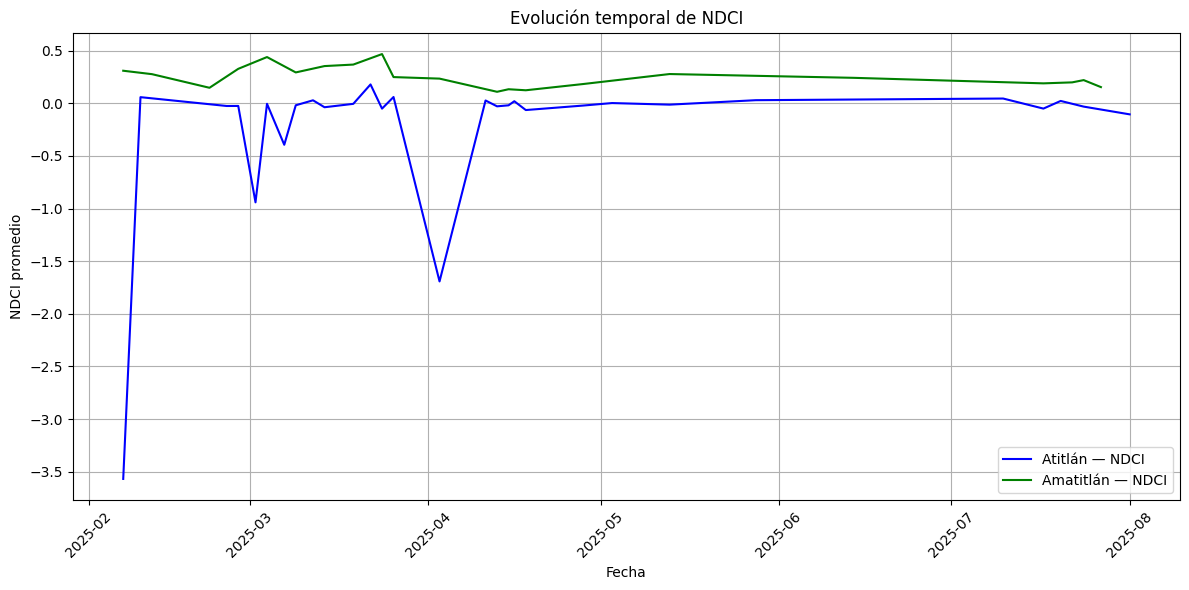

In [20]:
import matplotlib.pyplot as plt

def plot_ndci_timeseries(ts_atitlan, ts_amatitlan):
    plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico
    if len(ts_atitlan) > 0:
        plt.plot(ts_atitlan["date"], ts_atitlan["ndci_mean"], label="Atitlán — NDCI", color='blue')
    if len(ts_amatitlan) > 0:
        plt.plot(ts_amatitlan["date"], ts_amatitlan["ndci_mean"], label="Amatitlán — NDCI", color='green')
    
    plt.xlabel("Fecha")
    plt.ylabel("NDCI promedio")
    plt.title("Evolución temporal de NDCI")
    plt.legend()
    plt.xticks(rotation=45)  # Rotar etiquetas de fecha para mejor visibilidad
    plt.tight_layout()  # Ajustar el diseño del gráfico
    plt.show()

# Ejemplo de uso:
plot_ndci_timeseries(ts_atitlan, ts_amatitlan)


In [21]:
def detect_peaks(ts_df, thr=0.10):
    # Filtra los valores de NDCI que superan el umbral (thr)
    return ts_df[ts_df["ndci_mean"] > thr].copy()

# Ejemplo de uso:
peaks_atitlan = detect_peaks(ts_atitlan, thr=0.10)
peaks_amatitlan = detect_peaks(ts_amatitlan, thr=0.10)

# Mostrar los primeros picos detectados:
print("Picos Atitlán:")
display(peaks_atitlan.head())

print("Picos Amatitlán:")
display(peaks_amatitlan.head())


Picos Atitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
11,2025-03-22,0.179192,-0.024002,0.948223


Picos Amatitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,0.309353,-0.896521,0.634167
1,2025-02-12,0.276768,-0.077291,0.347577
2,2025-02-22,0.147389,-0.005949,0.185514
3,2025-02-27,0.327402,0.065662,0.232360
4,2025-03-04,0.439353,0.228353,0.145146


## 7) Análisis espacial: mapas de NDCI
Muestra mapas raster sencillos (matplotlib). Para mapas interactivos, puedes usar **folium** y `ImageOverlay`.

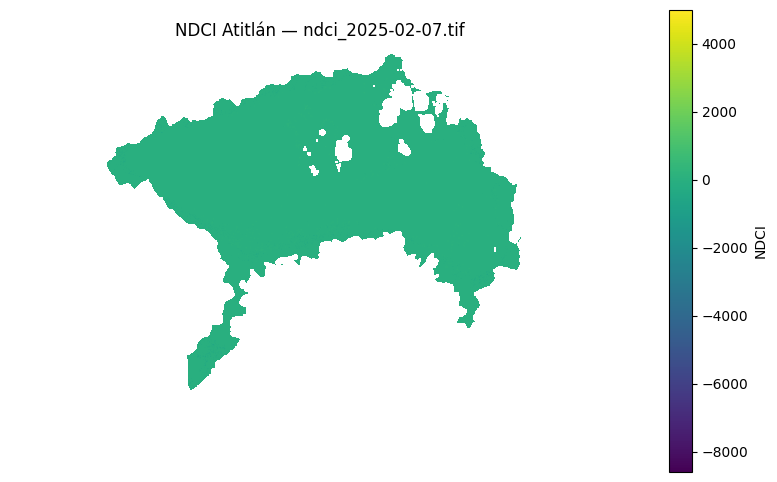

In [25]:
import matplotlib.pyplot as plt
import rasterio

def show_map_example(path_tif, title="Mapa NDCI"):
    """ Muestra un mapa sencillo de NDCI usando matplotlib """
    with rasterio.open(path_tif) as src:
        arr = src.read(1)  # NDCI (en caso de que el raster tenga varias bandas, esta toma la primera banda)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(arr, cmap='viridis')  # Puedes usar diferentes colormaps, como 'viridis', 'inferno', etc.
        plt.colorbar(label="NDCI")
        plt.title(title)
        plt.axis("off")  # Quita los ejes para una visualización más limpia
        plt.show()

# Ejemplo (ajusta la ruta a un archivo existente):
import os
import glob

tifs_atitlan = sorted(glob.glob("out_atitlan/**/*.tif", recursive=True))
if tifs_atitlan:
    show_map_example(tifs_atitlan[0], title=f"NDCI Atitlán — {os.path.basename(tifs_atitlan[0])}")


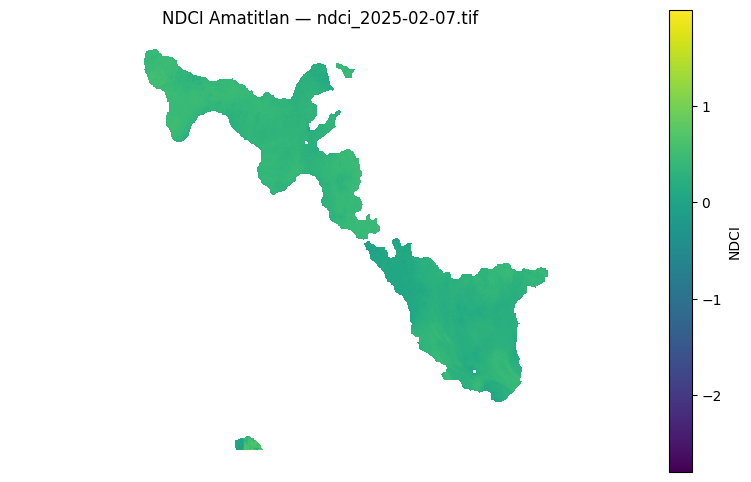

In [26]:
import matplotlib.pyplot as plt
import rasterio

def show_map_example(path_tif, title="Mapa NDCI"):
    """ Muestra un mapa sencillo de NDCI usando matplotlib """
    with rasterio.open(path_tif) as src:
        arr = src.read(1)  # NDCI (en caso de que el raster tenga varias bandas, esta toma la primera banda)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(arr, cmap='viridis')  # Puedes usar diferentes colormaps, como 'viridis', 'inferno', etc.
        plt.colorbar(label="NDCI")
        plt.title(title)
        plt.axis("off")  # Quita los ejes para una visualización más limpia
        plt.show()

# Ejemplo (ajusta la ruta a un archivo existente):
import os
import glob

tifs_atitlan = sorted(glob.glob("out_amatitlan/**/*.tif", recursive=True))
if tifs_atitlan:
    show_map_example(tifs_atitlan[0], title=f"NDCI Amatitlan — {os.path.basename(tifs_atitlan[0])}")


## 8) Correlación NDCI con NDVI/NDWI

In [27]:
def corr_table(ts_df):
    """ Calcula la correlación entre NDCI, NDVI y NDWI """
    return ts_df[["ndci_mean", "ndvi_mean", "ndwi_mean"]].corr()

# Ejemplo de uso:
corr_atitlan = corr_table(ts_atitlan)
corr_amatitlan = corr_table(ts_amatitlan)

# Mostrar la correlación para ambos lagos
display(corr_atitlan, corr_amatitlan)


,ndci_mean,ndvi_mean,ndwi_mean
ndci_mean,1.000000,0.489191,-0.945506
ndvi_mean,0.489191,1.000000,-0.422067
ndwi_mean,-0.945506,-0.422067,1.000000


,ndci_mean,ndvi_mean,ndwi_mean
ndci_mean,1.000000,0.337821,-0.153825
ndvi_mean,0.337821,1.000000,-0.910529
ndwi_mean,-0.153825,-0.910529,1.000000


## 9) Modelos
### 9.1 Serie temporal (ARIMA básico sobre `ndci_mean`)
Ajusta órdenes (p,d,q) tras revisar ACF/PACF.

In [28]:
!pip install statsmodels


In [29]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def arima_forecast(ts_df, steps=4):
    """ Ajusta un modelo ARIMA (p,d,q) y predice los siguientes pasos """
    # Establecemos la fecha como índice y completamos datos faltantes
    y = ts_df.set_index("date")["ndci_mean"].asfreq("7D").interpolate()

    # Definir el modelo ARIMA (p=1, d=0, q=1) como ejemplo
    model = sm.tsa.ARIMA(y, order=(1, 0, 1))  # Puedes ajustar p, d, q según ACF/PACF
    res = model.fit()  # Ajuste del modelo ARIMA
    
    # Realizar la predicción para los próximos 'steps' (por ejemplo, 4 pasos)
    fc = res.get_forecast(steps=steps)
    print(res.summary())  # Imprimir los resultados del modelo
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="NDCI Real")
    plt.plot(fc.predicted_mean, label="Predicción ARIMA", color='red')
    plt.fill_between(fc.conf_int().index, 
                     fc.conf_int().iloc[:, 0], 
                     fc.conf_int().iloc[:, 1], 
                     color='pink', alpha=0.3, label="Intervalo de Confianza")
    plt.title("Predicción ARIMA sobre NDCI")
    plt.xlabel("Fecha")
    plt.ylabel("NDCI Promedio")
    plt.legend()
    plt.show()

    return y, fc

# Ejemplo para Atitlán y Amatitlán (cuando tengas ts_*):
# y_at, fc_at = arima_forecast(ts_atitlan, steps=4)
# y_am, fc_am = arima_forecast(ts_amatitlan, steps=4)


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   26
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   3.439
Date:                Fri, 15 Aug 2025   AIC                              1.122
Time:                        00:32:30   BIC                              6.154
Sample:                    02-07-2025   HQIC                             2.571
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6929      1.714     -0.988      0.323      -5.052       1.667
ar.L1          0.9804      0.083     11.870      0.000       0.819       1.142
ma.L1          0.9442      1.500      0.629      0.5

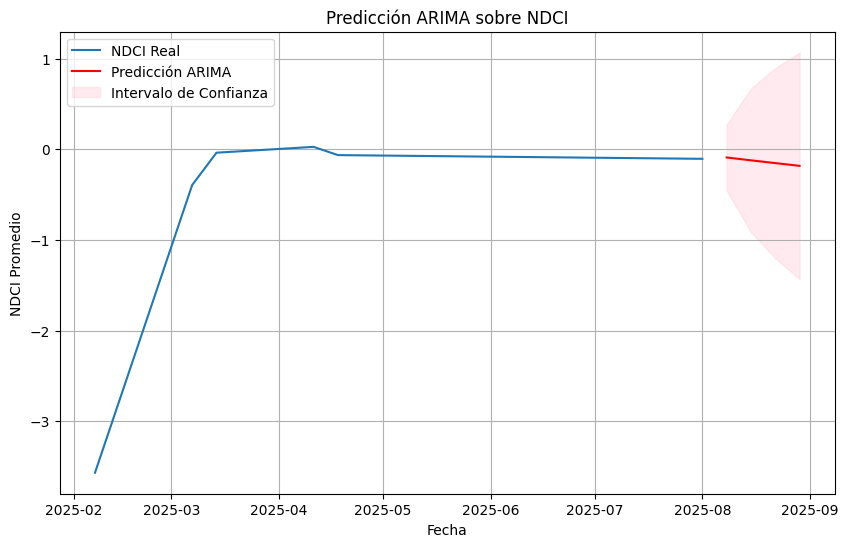

                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   25
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  65.872
Date:                Fri, 15 Aug 2025   AIC                           -123.743
Time:                        00:32:32   BIC                           -118.868
Sample:                    02-07-2025   HQIC                          -122.391
                         - 07-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2068      0.078      2.665      0.008       0.055       0.359
ar.L1          0.9610      0.074     13.016      0.000       0.816       1.106
ma.L1          0.5819      0.169      3.434      0.0

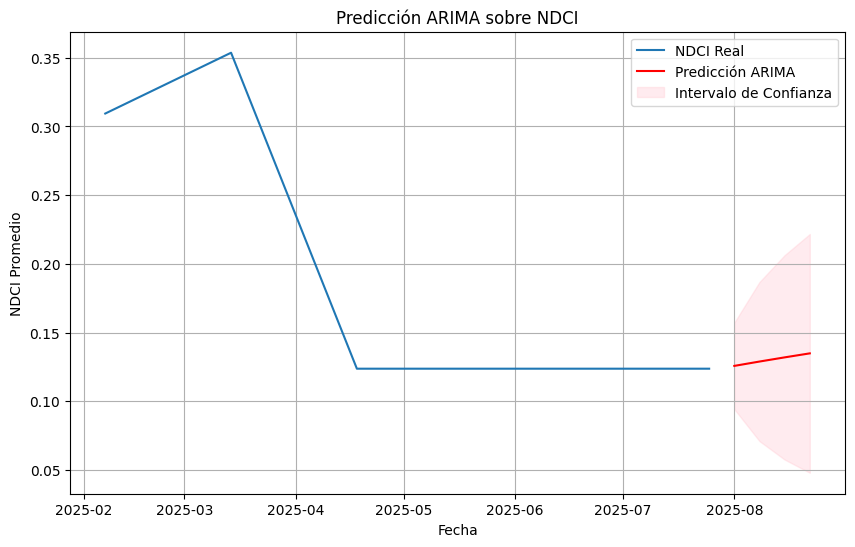

In [30]:
# Para Atitlán:
y_at, fc_at = arima_forecast(ts_atitlan, steps=4)

# Para Amatitlán:
y_am, fc_am = arima_forecast(ts_amatitlan, steps=4)


### 9.2 Clasificación (¿hay cianobacteria en un píxel? 1/0)
Usa NDVI/NDWI como *features* y un umbral de NDCI para etiquetas.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def build_xy_from_tif(path_tif, ndci_thr=0.10):
    with rasterio.open(path_tif) as src:
        ndci = src.read(1); ndvi = src.read(2); ndwi = src.read(3)
    mask = ~np.isnan(ndci) & ~np.isnan(ndvi) & ~np.isnan(ndwi)
    X = np.column_stack([ndvi[mask], ndwi[mask]])
    y = (ndci[mask] > ndci_thr).astype(int)
    return X, y

def train_logreg_on_tif(path_tif, ndci_thr=0.10):
    X, y = build_xy_from_tif(path_tif, ndci_thr=ndci_thr)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
    print(classification_report(yte, clf.predict(Xte)))
    return clf

# Ejemplo (ajusta la ruta):
# sample_tif = sorted(glob.glob("out_atitlan/**/*.tif", recursive=True))[0]
# clf = train_logreg_on_tif(sample_tif, ndci_thr=0.10)

Archivos de Atitlán: ['out_atitlan\\ndci\\ndci_2025-02-07.tif', 'out_atitlan\\ndci\\ndci_2025-02-10.tif', 'out_atitlan\\ndci\\ndci_2025-02-25.tif', 'out_atitlan\\ndci\\ndci_2025-02-27.tif', 'out_atitlan\\ndci\\ndci_2025-03-02.tif', 'out_atitlan\\ndci\\ndci_2025-03-04.tif', 'out_atitlan\\ndci\\ndci_2025-03-07.tif', 'out_atitlan\\ndci\\ndci_2025-03-09.tif', 'out_atitlan\\ndci\\ndci_2025-03-12.tif', 'out_atitlan\\ndci\\ndci_2025-03-14.tif', 'out_atitlan\\ndci\\ndci_2025-03-19.tif', 'out_atitlan\\ndci\\ndci_2025-03-22.tif', 'out_atitlan\\ndci\\ndci_2025-03-24.tif', 'out_atitlan\\ndci\\ndci_2025-03-26.tif', 'out_atitlan\\ndci\\ndci_2025-04-03.tif', 'out_atitlan\\ndci\\ndci_2025-04-11.tif', 'out_atitlan\\ndci\\ndci_2025-04-13.tif', 'out_atitlan\\ndci\\ndci_2025-04-15.tif', 'out_atitlan\\ndci\\ndci_2025-04-16.tif', 'out_atitlan\\ndci\\ndci_2025-04-18.tif', 'out_atitlan\\ndci\\ndci_2025-04-28.tif', 'out_atitlan\\ndci\\ndci_2025-05-03.tif', 'out_atitlan\\ndci\\ndci_2025-05-13.tif', 'out_atitlan

IndexError: band index 2 out of range (not in (1,))

### 9.3 Modelo híbrido
Primero pronostica `ndci_mean` (ARIMA) y úsalo como *feature* adicional (junto a NDVI/NDWI y otras variables) para clasificar si un área estará contaminada.

In [ ]:
# Esqueleto de híbrido (ajústalo a tu pipeline de datos)
def hybrid_features_from_tif(path_tif, ndci_forecast_scalar, ndci_thr=0.10):
    with rasterio.open(path_tif) as src:
        ndci = src.read(1); ndvi = src.read(2); ndwi = src.read(3)
    mask = ~np.isnan(ndci) & ~np.isnan(ndvi) & ~np.isnan(ndwi)
    X = np.column_stack([ndvi[mask], ndwi[mask], np.full(mask.sum(), ndci_forecast_scalar, dtype=float)])
    y = (ndci[mask] > ndci_thr).astype(int)
    return X, y

# Ejemplo de entrenamiento cuando tengas un pronóstico escalar del lago (p.ej. media pronosticada):
# ndci_fc_scalar = float(fc_at.predicted_mean.mean())
# Xh, yh = hybrid_features_from_tif(sample_tif, ndci_fc_scalar, ndci_thr=0.10)
# Xtr, Xte, ytr, yte = train_test_split(Xh, yh, test_size=0.3, random_state=42)
# clf_h = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
# print(classification_report(yte, clf_h.predict(Xte)))

## 10) Visualización de proyecciones en mapa
Aplica el clasificador píxel a píxel para construir un raster binario (0/1) y muéstralo.

In [ ]:
def project_map_from_classifier(path_tif, clf, ndci_forecast_scalar=None):
    with rasterio.open(path_tif) as src:
        profile = src.profile
        ndci = src.read(1); ndvi = src.read(2); ndwi = src.read(3)
    mask = ~np.isnan(ndvi) & ~np.isnan(ndwi)
    if ndci_forecast_scalar is None:
        X = np.column_stack([ndvi[mask], ndwi[mask]])
    else:
        X = np.column_stack([ndvi[mask], ndwi[mask], np.full(mask.sum(), ndci_forecast_scalar, dtype=float)])
    yhat = np.zeros_like(ndvi, dtype=float)
    yhat[mask] = clf.predict(X)
    plt.figure()
    plt.imshow(yhat)
    plt.title("Proyección binaria (1=probable cianobacteria)")
    plt.axis("off")
    plt.show()
    return yhat

# Ejemplo (ajusta rutas y modelos antes de ejecutar):
# yhat_map = project_map_from_classifier(sample_tif, clf)

## Notas finales
- Ajusta el **umbral NDCI** según literatura/valores observados.
- Para robustez, promedia múltiples fechas cercanas antes de clasificar.
- Incorpora variables externas (p. ej., temperatura/precipitación de Weatherspark) para el modelo híbrido.
- Versiona tu trabajo y documenta decisiones de preprocesamiento y modelos.
